In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xclone
import os

(Running XClone 0.4.0)
2026-02-06 16:46:05


In [13]:
h5 = sc.read_h5ad("R310_pre/R310_pre_data_R310_pre_cb_processed.h5")

In [16]:
data_dir = "R310_pre/1a_outs/"   # <-- change me

AD_file = data_dir + "cellSNP.tag.AD.mtx"   # <-- change filenames if needed
DP_file = data_dir + "cellSNP.tag.DP.mtx"
barcodes_file = data_dir + "cellSNP.samples.tsv"


bars = pd.read_csv(barcodes_file, sep='\t', header=None)

In [17]:
use = np.intersect1d(bars[0], h5.obs_names)

In [18]:
types = list(h5.obs.loc[use]["celltype_bped_main"])

In [19]:
ref_key = []
for i in range(len(types)):
    if types[i]=="Melanocytes":
        ref_key.append("cancer")
    elif types[i] in ["CD8+ T-cells","CD4+ T-cells","B-cells"]:
        ref_key.append("T/B cells")
    else:
        ref_key.append("drop")

In [20]:
h5 = h5[use]

In [21]:
h5.obs["ref_key"] = ref_key

/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_75729/2037193548.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  h5.obs["ref_key"] = ref_key


In [22]:
h5 = h5[h5.obs["ref_key"]!="drop"]

In [23]:
# Build AnnData for BAF module (layers AD and DP)
BAF_adata = xclone.pp.xclonedata(
    [AD_file, DP_file],
    data_mode="BAF",
    mtx_barcodes_file=barcodes_file,
    genome_mode="hg19_genes",   # or "hg19_genes"
)

print(BAF_adata)
print(BAF_adata.layers.keys())   # should include 'AD' and 'DP'

BAF_adata.write_h5ad(data_dir + "BAF_input.h5ad")

/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 13406 × 32696
    var: 'GeneName', 'GeneID', 'chr', 'start', 'stop', 'arm', 'chr_arm', 'band'
    uns: 'log', 'data_mode', 'genome_mode', 'data_notes'
    layers: 'AD', 'DP'
KeysView(Layers with keys: AD, DP)


In [24]:
data_dir = "R310_pre/1a_outs/"
outdir = "R310_pre/xclone_out/"
os.makedirs(outdir, exist_ok=True)

BAF_adata = sc.read(data_dir + "BAF_input.h5ad")

dataset_name = "R310_pre"
xconfig = xclone.XCloneConfig(dataset_name=dataset_name, module="BAF")
xconfig.outdir = outdir

In [25]:
BAF_adata = BAF_adata[h5.obs_names]

In [26]:
BAF_adata.obs["celltype"] = h5.obs["ref_key"]

/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_75729/317067202.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  BAF_adata.obs["celltype"] = h5.obs["ref_key"]


In [27]:
pd.DataFrame(BAF_adata.obs_names).to_csv("R310_pre/use_barcodes.tsv",sep='\t')

In [28]:
pd.DataFrame(BAF_adata.var_names).to_csv("R310_pre/features.tsv",sep='\t')

In [72]:
from scipy.io import mmread
from scipy.sparse import csr_matrix
import anndata as ad
RDR_mtx = "R310_pre/RDR_pre/matrix.mtx"
barcodes = "R310_pre/RDR_pre/barcodes.tsv"          # must be 1 barcode per line (no index col)
regions  = "R310_pre/RDR_pre/features.tsv"         # your 4-col regions file (57,820 rows)

X = mmread(RDR_mtx).tocsr()                # this is (features, cells) = (57820, 9829)

# barcodes: if your barcodes.tsv is clean one-col, this works
bc = pd.read_csv(barcodes, header=None, sep="\t")[0].astype(str).tolist()

# regions: 4 cols chrom/start/end/name
reg = pd.read_csv(regions, header=None, sep="\t")
reg = reg.iloc[:, :4]
reg.columns = ["chrom", "start", "end", "name"]
reg["name"] = reg["name"].astype(str)

assert X.shape[0] == len(reg), (X.shape, len(reg))
assert X.shape[1] == len(bc), (X.shape, len(bc))

# Transpose to cells x features for AnnData
adata = ad.AnnData(
    X=csr_matrix(X.T),                     # (9829, 57820)
    obs=pd.DataFrame(index=bc),
    var=pd.DataFrame(index=reg["name"].values),
)
adata.var["chrom"] = reg["chrom"].values
adata.var["start"] = reg["start"].astype(int).values
adata.var["end"]   = reg["end"].astype(int).values

adata.write_h5ad("R310_pre/RDR_pre/RDR_input.h5ad")
print(adata)

AnnData object with n_obs × n_vars = 9829 × 57820
    var: 'chrom', 'start', 'end'


In [80]:
RDR_adata = adata[BAF_adata.obs_names]

In [103]:
RDR_adata.obs = BAF_adata.obs
RDR_adata.layers["raw_expr"] = RDR.X 
RDR_adata.var_names_make_unique()
RDR_adata.var["GeneName"] = RDR_adata.var.index.astype(str)
RDR_adata.write_h5ad("R310_pre/RDR_pre/RDR_input.mapped.h5ad")

In [108]:
var = RDR_adata.var.copy()
var["mid"] = ((var["start"].astype(int) + var["end"].astype(int)) // 2)

cyto = pd.read_csv("cytoBand.txt", sep="\t", header=None,
                   names=["chrom","start","end","band","stain"])

# centromere ranges (acen)
acen = cyto[cyto["stain"] == "acen"].copy()

# make a dict chrom -> centromere midpoint
cent = (
    acen.groupby("chrom")[["start","end"]]
    .agg({"start":"min","end":"max"})
)
cent["cent_mid"] = (cent["start"] + cent["end"]) // 2

# map chrom -> cent_mid, then assign p/q
var = var.join(cent["cent_mid"], on="chrom")
var["chr_arm"] = np.where(var["mid"] <= var["cent_mid"], var["chrom"] + "p", var["chrom"] + "q")

RDR_adata.var["chr_arm"] = var["chr_arm"].values
RDR_adata.var["chr"] = var["chrom"].astype(str) 
RDR_adata.var["stop"] = var["end"].astype(int)
RDR_adata.write_h5ad("R310_pre/RDR_pre/RDR_input.mapped.h5ad")

[XClone RDR module running]************************
[XClone data preprocessing] check RDR raw dataset value: success
Keep valid cells: Filter out 0 cells / 9828 total cells, remain 9828 valid cells with annotation
[XClone data preprocessing] check RDR cell annotation: success
[XClone-RDR preprocessing] Filter out 48327 genes / 57820 total genes, remain 9493 genes
[XClone data preprocessing] detect RDR genes: done
filter_ref_ave_recomend 0.02912621359223301
[XClone-RDR preprocessing] Filter out 3269 genes / 9493 total genes, remain 6224 genes
[XClone-RDR preprocessing] Filter out 0 cells / 9828 total cells, remain 9828 cells
[XClone] use marker genes provided by users: 
 ['ABCB5' 'AC009499.1' 'AC018755.1' 'AC096559.1' 'ACACA' 'FAM19A2' 'FAM65B'
 'FMN1' 'GLCE' 'GPC6' 'HECW2' 'IL1RAPL1' 'LINC00504' 'MT-ATP6' 'MT-CO1'
 'MT-CO2' 'MT-CYB' 'MT-ND1' 'MT-ND4' 'MT-ND4L' 'MT-ND5' 'MT-RNR1'
 'MT-RNR2' 'NLGN1' 'NOX4' 'NPAS3' 'RP11-1000B6.3' 'RP11-384J4.2'
 'RP11-702L6.4' 'SOX6']
filter_genes_num: 3

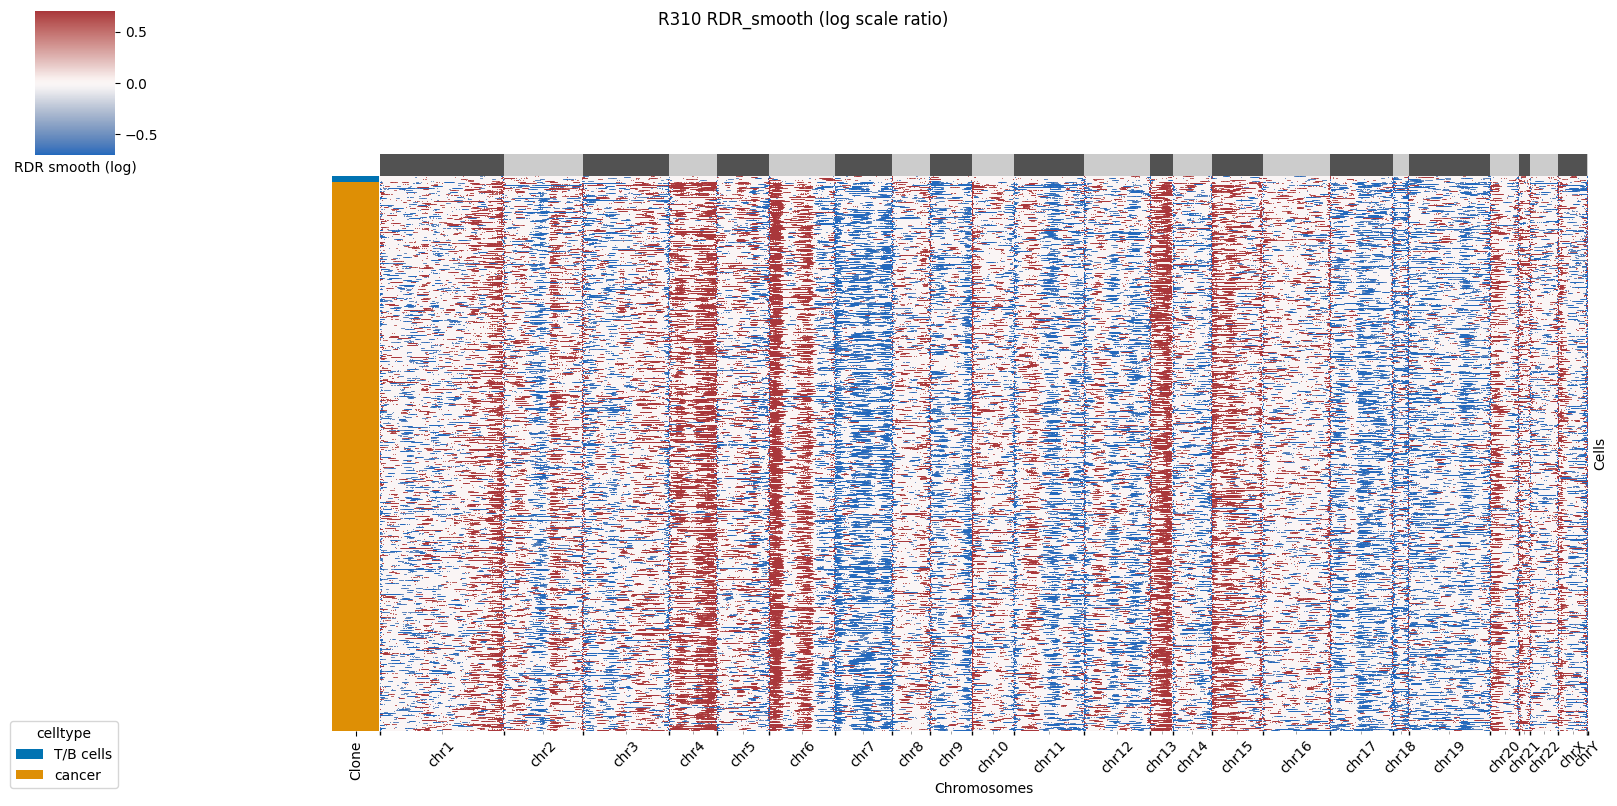

(Running XClone 0.4.0)
2026-02-06 04:02:57
(Running XClone 0.4.0)
2026-02-06 04:13:53


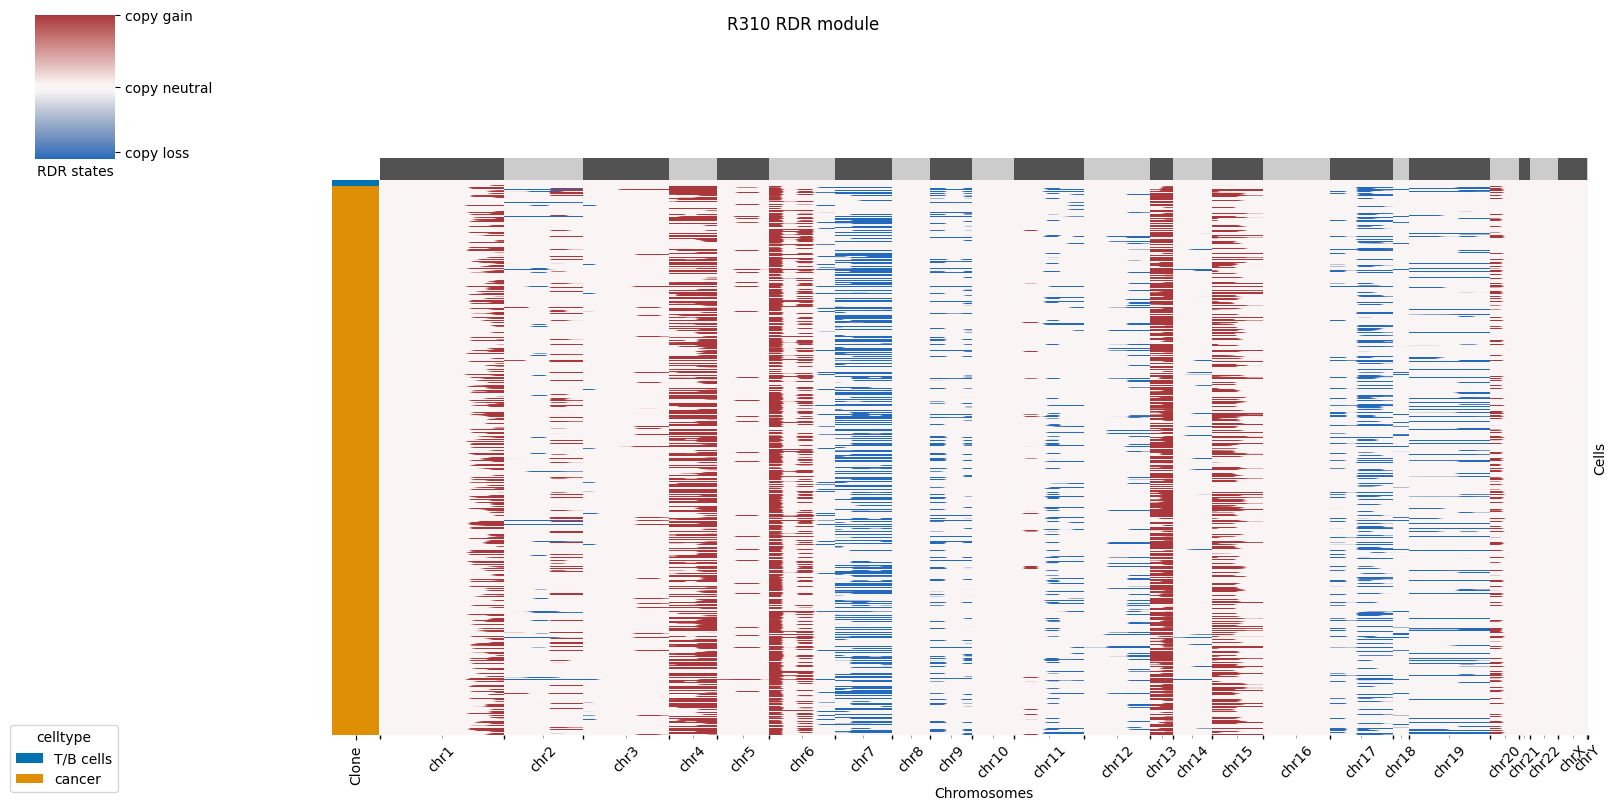

(Running XClone 0.4.0)
2026-02-06 04:13:53
(Running XClone 0.4.0)
2026-02-06 04:02:06
(Running XClone 0.4.0)
2026-02-06 04:06:07
(Running XClone 0.4.0)
2026-02-06 04:13:54
(Running XClone 0.4.0)
2026-02-06 04:06:07
(Running XClone 0.4.0)
2026-02-06 04:13:53
(Running XClone 0.4.0)
2026-02-06 04:13:53
(Running XClone 0.4.0)
2026-02-06 04:13:53
(Running XClone 0.4.0)
2026-02-06 04:02:48
(Running XClone 0.4.0)
2026-02-06 04:06:07


In [109]:
outdir = "R310_pre/xclone_out/"
os.makedirs(outdir, exist_ok=True)

RDR = ad.read_h5ad("R310_pre/RDR_pre/RDR_input.mapped.h5ad")

xconfig_rdr = xclone.XCloneConfig(dataset_name="R310", module="RDR")
xconfig_rdr.outdir = outdir
xconfig_rdr.cell_anno_key = "celltype"
xconfig_rdr.ref_celltype = "T/B cells"   # adjust

RDR_res = xclone.model.run_RDR(RDR, config_file=xconfig_rdr)
RDR_res.write_h5ad(os.path.join(outdir, "RDR_result.h5ad"))

[XClone BAF module running]************************
[XClone data preprocessing] check BAF raw dataset value: success
Keep valid cells: Filter out 0 cells / 9828 total cells, remain 9828 valid cells with annotation
[XClone data preprocessing] check BAF cell annotation: success


/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:55: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T @ Z + BD.T @ (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:73: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T * Z + BD.T * (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:76: RuntimeWarning: divide by zero encountered in log
  _logLik_mat = (AD * np.log(thetas) + BD * np.log(1 - thetas))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:55: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T @ Z + BD.T @ (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:73: RuntimeWarning: invalid value encou

(Running XClone 0.4.0)
2026-02-06 15:47:32
(Running XClone 0.4.0)
2026-02-06 15:47:32
(Running XClone 0.4.0)
2026-02-06 15:47:32
(Running XClone 0.4.0)
2026-02-06 15:47:32
(Running XClone 0.4.0)
2026-02-06 15:47:32
(Running XClone 0.4.0)
2026-02-06 15:47:32
(Running XClone 0.4.0)
2026-02-06 15:47:32
(Running XClone 0.4.0)
2026-02-06 15:47:32
(Running XClone 0.4.0)
2026-02-06 15:47:32
(Running XClone 0.4.0)
2026-02-06 15:47:32
(Running XClone 0.4.0)
2026-02-06 15:47:32
(Running XClone 0.4.0)
2026-02-06 15:47:32
(Running XClone 0.4.0)
2026-02-06 15:47:32
(Running XClone 0.4.0)
2026-02-06 15:47:32
(Running XClone 0.4.0)
2026-02-06 15:47:32
(Running XClone 0.4.0)
2026-02-06 15:47:32
(Running XClone 0.4.0)
2026-02-06 15:47:32
(Running XClone 0.4.0)
2026-02-06 15:47:32
(Running XClone 0.4.0)
2026-02-06 15:47:32
(Running XClone 0.4.0)
2026-02-06 15:47:32


/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:55: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T @ Z + BD.T @ (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:73: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T * Z + BD.T * (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:76: RuntimeWarning: divide by zero encountered in log
  _logLik_mat = (AD * np.log(thetas) + BD * np.log(1 - thetas))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:55: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T @ Z + BD.T @ (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:73: RuntimeWarning: invalid value encou

(Running XClone 0.4.0)
2026-02-06 15:47:42
(Running XClone 0.4.0)
2026-02-06 15:47:42
(Running XClone 0.4.0)
2026-02-06 15:47:42
(Running XClone 0.4.0)
2026-02-06 15:47:42
(Running XClone 0.4.0)
2026-02-06 15:47:42
(Running XClone 0.4.0)
2026-02-06 15:47:42
(Running XClone 0.4.0)
2026-02-06 15:47:42
(Running XClone 0.4.0)
2026-02-06 15:47:42
(Running XClone 0.4.0)
2026-02-06 15:47:42
(Running XClone 0.4.0)
2026-02-06 15:47:42
(Running XClone 0.4.0)
2026-02-06 15:47:42
(Running XClone 0.4.0)
2026-02-06 15:47:42
(Running XClone 0.4.0)
2026-02-06 15:47:42
(Running XClone 0.4.0)
2026-02-06 15:47:42
(Running XClone 0.4.0)
2026-02-06 15:47:42
(Running XClone 0.4.0)
2026-02-06 15:47:42
(Running XClone 0.4.0)
2026-02-06 15:47:42
(Running XClone 0.4.0)
2026-02-06 15:47:42
(Running XClone 0.4.0)
2026-02-06 15:47:42
(Running XClone 0.4.0)
2026-02-06 15:47:42


/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:55: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T @ Z + BD.T @ (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:73: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T * Z + BD.T * (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:76: RuntimeWarning: divide by zero encountered in log
  _logLik_mat = (AD * np.log(thetas) + BD * np.log(1 - thetas))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:55: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T @ Z + BD.T @ (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:73: RuntimeWarning: invalid value encou

(Running XClone 0.4.0)
2026-02-06 15:47:53
(Running XClone 0.4.0)
2026-02-06 15:47:53
(Running XClone 0.4.0)
2026-02-06 15:47:53
(Running XClone 0.4.0)
2026-02-06 15:47:53
(Running XClone 0.4.0)
2026-02-06 15:47:53
(Running XClone 0.4.0)
2026-02-06 15:47:53
(Running XClone 0.4.0)
2026-02-06 15:47:53
(Running XClone 0.4.0)
2026-02-06 15:47:53
(Running XClone 0.4.0)
2026-02-06 15:47:53
(Running XClone 0.4.0)
2026-02-06 15:47:53
(Running XClone 0.4.0)
2026-02-06 15:47:53
(Running XClone 0.4.0)
2026-02-06 15:47:53
(Running XClone 0.4.0)
2026-02-06 15:47:53
(Running XClone 0.4.0)
2026-02-06 15:47:53
(Running XClone 0.4.0)
2026-02-06 15:47:53
(Running XClone 0.4.0)
2026-02-06 15:47:53
(Running XClone 0.4.0)
2026-02-06 15:47:53
(Running XClone 0.4.0)
2026-02-06 15:47:53


/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:55: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T @ Z + BD.T @ (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:73: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T * Z + BD.T * (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:76: RuntimeWarning: divide by zero encountered in log
  _logLik_mat = (AD * np.log(thetas) + BD * np.log(1 - thetas))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:55: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T @ Z + BD.T @ (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:73: RuntimeWarning: invalid value encou

(Running XClone 0.4.0)
2026-02-06 15:48:02
(Running XClone 0.4.0)
2026-02-06 15:48:02
(Running XClone 0.4.0)
2026-02-06 15:48:02
(Running XClone 0.4.0)
2026-02-06 15:48:02
(Running XClone 0.4.0)
2026-02-06 15:48:02
(Running XClone 0.4.0)
2026-02-06 15:48:02
(Running XClone 0.4.0)
2026-02-06 15:48:02
(Running XClone 0.4.0)
2026-02-06 15:48:02
(Running XClone 0.4.0)
2026-02-06 15:48:02
(Running XClone 0.4.0)
2026-02-06 15:48:02
(Running XClone 0.4.0)
2026-02-06 15:48:02
(Running XClone 0.4.0)
2026-02-06 15:48:02
(Running XClone 0.4.0)
2026-02-06 15:48:02
(Running XClone 0.4.0)
2026-02-06 15:48:02


/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:55: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T @ Z + BD.T @ (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:73: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T * Z + BD.T * (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:76: RuntimeWarning: divide by zero encountered in log
  _logLik_mat = (AD * np.log(thetas) + BD * np.log(1 - thetas))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:55: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T @ Z + BD.T @ (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:73: RuntimeWarning: invalid value encou

(Running XClone 0.4.0)
2026-02-06 15:48:09
(Running XClone 0.4.0)
2026-02-06 15:48:09
(Running XClone 0.4.0)
2026-02-06 15:48:09
(Running XClone 0.4.0)
2026-02-06 15:48:09
(Running XClone 0.4.0)
2026-02-06 15:48:09
(Running XClone 0.4.0)
2026-02-06 15:48:09
(Running XClone 0.4.0)
2026-02-06 15:48:09
(Running XClone 0.4.0)
2026-02-06 15:48:09
(Running XClone 0.4.0)
2026-02-06 15:48:09
(Running XClone 0.4.0)
2026-02-06 15:48:09
(Running XClone 0.4.0)
2026-02-06 15:48:09
(Running XClone 0.4.0)
2026-02-06 15:48:09
(Running XClone 0.4.0)
2026-02-06 15:48:09
(Running XClone 0.4.0)
2026-02-06 15:48:09
(Running XClone 0.4.0)
2026-02-06 15:48:09
(Running XClone 0.4.0)
2026-02-06 15:48:09
(Running XClone 0.4.0)
2026-02-06 15:48:09


/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:55: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T @ Z + BD.T @ (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:73: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T * Z + BD.T * (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:76: RuntimeWarning: divide by zero encountered in log
  _logLik_mat = (AD * np.log(thetas) + BD * np.log(1 - thetas))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:55: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T @ Z + BD.T @ (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:73: RuntimeWarning: invalid value encou

(Running XClone 0.4.0)
2026-02-06 15:48:18
(Running XClone 0.4.0)
2026-02-06 15:48:18
(Running XClone 0.4.0)
2026-02-06 15:48:18
(Running XClone 0.4.0)
2026-02-06 15:48:18
(Running XClone 0.4.0)
2026-02-06 15:48:18
(Running XClone 0.4.0)
2026-02-06 15:48:18
(Running XClone 0.4.0)
2026-02-06 15:48:18
(Running XClone 0.4.0)
2026-02-06 15:48:18
(Running XClone 0.4.0)
2026-02-06 15:48:18
(Running XClone 0.4.0)
2026-02-06 15:48:18
(Running XClone 0.4.0)
2026-02-06 15:48:18
(Running XClone 0.4.0)
2026-02-06 15:48:18
(Running XClone 0.4.0)
2026-02-06 15:48:18
(Running XClone 0.4.0)
2026-02-06 15:48:18
(Running XClone 0.4.0)
2026-02-06 15:48:18
(Running XClone 0.4.0)
2026-02-06 15:48:18
(Running XClone 0.4.0)
2026-02-06 15:48:18


/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:55: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T @ Z + BD.T @ (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:73: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T * Z + BD.T * (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:76: RuntimeWarning: divide by zero encountered in log
  _logLik_mat = (AD * np.log(thetas) + BD * np.log(1 - thetas))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:55: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T @ Z + BD.T @ (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:73: RuntimeWarning: invalid value encou

(Running XClone 0.4.0)
2026-02-06 15:48:27
(Running XClone 0.4.0)
2026-02-06 15:48:27
(Running XClone 0.4.0)
2026-02-06 15:48:27
(Running XClone 0.4.0)
2026-02-06 15:48:27
(Running XClone 0.4.0)
2026-02-06 15:48:27
(Running XClone 0.4.0)
2026-02-06 15:48:27
(Running XClone 0.4.0)
2026-02-06 15:48:27
(Running XClone 0.4.0)
2026-02-06 15:48:27
(Running XClone 0.4.0)
2026-02-06 15:48:27
(Running XClone 0.4.0)
2026-02-06 15:48:27
(Running XClone 0.4.0)
2026-02-06 15:48:27
(Running XClone 0.4.0)
2026-02-06 15:48:27
(Running XClone 0.4.0)
2026-02-06 15:48:27
(Running XClone 0.4.0)
2026-02-06 15:48:27
(Running XClone 0.4.0)
2026-02-06 15:48:27


/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:55: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T @ Z + BD.T @ (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:73: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T * Z + BD.T * (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:76: RuntimeWarning: divide by zero encountered in log
  _logLik_mat = (AD * np.log(thetas) + BD * np.log(1 - thetas))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:55: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T @ Z + BD.T @ (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:73: RuntimeWarning: invalid value encou

(Running XClone 0.4.0)
2026-02-06 15:48:35
(Running XClone 0.4.0)
2026-02-06 15:48:35
(Running XClone 0.4.0)
2026-02-06 15:48:35
(Running XClone 0.4.0)
2026-02-06 15:48:35
(Running XClone 0.4.0)
2026-02-06 15:48:35
(Running XClone 0.4.0)
2026-02-06 15:48:35
(Running XClone 0.4.0)
2026-02-06 15:48:35
(Running XClone 0.4.0)
2026-02-06 15:48:35
(Running XClone 0.4.0)
2026-02-06 15:48:35
(Running XClone 0.4.0)
2026-02-06 15:48:35
(Running XClone 0.4.0)
2026-02-06 15:48:35
(Running XClone 0.4.0)
2026-02-06 15:48:35
(Running XClone 0.4.0)
2026-02-06 15:48:35
(Running XClone 0.4.0)
2026-02-06 15:48:35


/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:55: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T @ Z + BD.T @ (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:73: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T * Z + BD.T * (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:76: RuntimeWarning: divide by zero encountered in log
  _logLik_mat = (AD * np.log(thetas) + BD * np.log(1 - thetas))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:55: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T @ Z + BD.T @ (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:73: RuntimeWarning: invalid value encou

(Running XClone 0.4.0)
2026-02-06 15:48:43
(Running XClone 0.4.0)
2026-02-06 15:48:43
(Running XClone 0.4.0)
2026-02-06 15:48:43
(Running XClone 0.4.0)
2026-02-06 15:48:43
(Running XClone 0.4.0)
2026-02-06 15:48:43
(Running XClone 0.4.0)
2026-02-06 15:48:43
(Running XClone 0.4.0)
2026-02-06 15:48:43
(Running XClone 0.4.0)
2026-02-06 15:48:43
(Running XClone 0.4.0)
2026-02-06 15:48:43
(Running XClone 0.4.0)
2026-02-06 15:48:43
(Running XClone 0.4.0)
2026-02-06 15:48:43
(Running XClone 0.4.0)
2026-02-06 15:48:43
(Running XClone 0.4.0)
2026-02-06 15:48:43


/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:55: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T @ Z + BD.T @ (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:73: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T * Z + BD.T * (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:76: RuntimeWarning: divide by zero encountered in log
  _logLik_mat = (AD * np.log(thetas) + BD * np.log(1 - thetas))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:55: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T @ Z + BD.T @ (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:55: RuntimeWarning: invalid value encou

(Running XClone 0.4.0)
2026-02-06 15:48:50
(Running XClone 0.4.0)
2026-02-06 15:48:50
(Running XClone 0.4.0)
2026-02-06 15:48:50
(Running XClone 0.4.0)
2026-02-06 15:48:50
(Running XClone 0.4.0)
2026-02-06 15:48:50
(Running XClone 0.4.0)
2026-02-06 15:48:50
(Running XClone 0.4.0)
2026-02-06 15:48:50
(Running XClone 0.4.0)
2026-02-06 15:48:50
(Running XClone 0.4.0)
2026-02-06 15:48:50
(Running XClone 0.4.0)
2026-02-06 15:48:50
(Running XClone 0.4.0)
2026-02-06 15:48:50
(Running XClone 0.4.0)
2026-02-06 15:48:50
(Running XClone 0.4.0)
2026-02-06 15:48:50


/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:55: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T @ Z + BD.T @ (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:73: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T * Z + BD.T * (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:76: RuntimeWarning: divide by zero encountered in log
  _logLik_mat = (AD * np.log(thetas) + BD * np.log(1 - thetas))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:55: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T @ Z + BD.T @ (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:73: RuntimeWarning: invalid value encou

(Running XClone 0.4.0)
2026-02-06 15:48:58
(Running XClone 0.4.0)
2026-02-06 15:48:58
(Running XClone 0.4.0)
2026-02-06 15:48:58
(Running XClone 0.4.0)
2026-02-06 15:48:58
(Running XClone 0.4.0)
2026-02-06 15:48:58
(Running XClone 0.4.0)
2026-02-06 15:48:58
(Running XClone 0.4.0)
2026-02-06 15:48:58
(Running XClone 0.4.0)
2026-02-06 15:48:58
(Running XClone 0.4.0)
2026-02-06 15:48:58
(Running XClone 0.4.0)
2026-02-06 15:48:58
(Running XClone 0.4.0)
2026-02-06 15:48:58
(Running XClone 0.4.0)
2026-02-06 15:48:58
(Running XClone 0.4.0)
2026-02-06 15:48:58
(Running XClone 0.4.0)
2026-02-06 15:48:58
(Running XClone 0.4.0)
2026-02-06 15:48:58
(Running XClone 0.4.0)
2026-02-06 15:48:58
(Running XClone 0.4.0)
2026-02-06 15:48:58
(Running XClone 0.4.0)
2026-02-06 15:48:58
(Running XClone 0.4.0)
2026-02-06 15:48:58


/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:55: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T @ Z + BD.T @ (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:73: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T * Z + BD.T * (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:76: RuntimeWarning: divide by zero encountered in log
  _logLik_mat = (AD * np.log(thetas) + BD * np.log(1 - thetas))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:55: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T @ Z + BD.T @ (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:73: RuntimeWarning: invalid value encou

(Running XClone 0.4.0)
2026-02-06 15:49:07
(Running XClone 0.4.0)
2026-02-06 15:49:07
(Running XClone 0.4.0)
2026-02-06 15:49:07
(Running XClone 0.4.0)
2026-02-06 15:49:07
(Running XClone 0.4.0)
2026-02-06 15:49:07
(Running XClone 0.4.0)
2026-02-06 15:49:07
(Running XClone 0.4.0)
2026-02-06 15:49:07
(Running XClone 0.4.0)
2026-02-06 15:49:07
(Running XClone 0.4.0)
2026-02-06 15:49:07
(Running XClone 0.4.0)
2026-02-06 15:49:07
(Running XClone 0.4.0)
2026-02-06 15:49:07
(Running XClone 0.4.0)
2026-02-06 15:49:07
(Running XClone 0.4.0)
2026-02-06 15:49:07
(Running XClone 0.4.0)
2026-02-06 15:49:07
(Running XClone 0.4.0)
2026-02-06 15:49:07
(Running XClone 0.4.0)
2026-02-06 15:49:07
(Running XClone 0.4.0)
2026-02-06 15:49:07


/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:55: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T @ Z + BD.T @ (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:73: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T * Z + BD.T * (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:76: RuntimeWarning: divide by zero encountered in log
  _logLik_mat = (AD * np.log(thetas) + BD * np.log(1 - thetas))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:55: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T @ Z + BD.T @ (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:73: RuntimeWarning: invalid value encou

(Running XClone 0.4.0)
2026-02-06 15:49:16
(Running XClone 0.4.0)
2026-02-06 15:49:16
(Running XClone 0.4.0)
2026-02-06 15:49:16
(Running XClone 0.4.0)
2026-02-06 15:49:16
(Running XClone 0.4.0)
2026-02-06 15:49:16
(Running XClone 0.4.0)
2026-02-06 15:49:16


/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:55: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T @ Z + BD.T @ (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:73: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T * Z + BD.T * (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:76: RuntimeWarning: divide by zero encountered in log
  _logLik_mat = (AD * np.log(thetas) + BD * np.log(1 - thetas))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:55: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T @ Z + BD.T @ (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:73: RuntimeWarning: invalid value encou

(Running XClone 0.4.0)
2026-02-06 15:49:22
(Running XClone 0.4.0)
2026-02-06 15:49:22
(Running XClone 0.4.0)
2026-02-06 15:49:22
(Running XClone 0.4.0)
2026-02-06 15:49:22
(Running XClone 0.4.0)
2026-02-06 15:49:22
(Running XClone 0.4.0)
2026-02-06 15:49:22
(Running XClone 0.4.0)
2026-02-06 15:49:22
(Running XClone 0.4.0)
2026-02-06 15:49:22
(Running XClone 0.4.0)
2026-02-06 15:49:22
(Running XClone 0.4.0)
2026-02-06 15:49:22
(Running XClone 0.4.0)
2026-02-06 15:49:22


/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:55: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T @ Z + BD.T @ (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:73: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T * Z + BD.T * (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:76: RuntimeWarning: divide by zero encountered in log
  _logLik_mat = (AD * np.log(thetas) + BD * np.log(1 - thetas))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:55: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T @ Z + BD.T @ (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:73: RuntimeWarning: invalid value encou

(Running XClone 0.4.0)
2026-02-06 15:49:29
(Running XClone 0.4.0)
2026-02-06 15:49:29
(Running XClone 0.4.0)
2026-02-06 15:49:29
(Running XClone 0.4.0)
2026-02-06 15:49:29
(Running XClone 0.4.0)
2026-02-06 15:49:29
(Running XClone 0.4.0)
2026-02-06 15:49:29
(Running XClone 0.4.0)
2026-02-06 15:49:29
(Running XClone 0.4.0)
2026-02-06 15:49:29
(Running XClone 0.4.0)
2026-02-06 15:49:29
(Running XClone 0.4.0)
2026-02-06 15:49:29
(Running XClone 0.4.0)
2026-02-06 15:49:29


/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:55: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T @ Z + BD.T @ (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:73: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T * Z + BD.T * (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:76: RuntimeWarning: divide by zero encountered in log
  _logLik_mat = (AD * np.log(thetas) + BD * np.log(1 - thetas))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:55: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T @ Z + BD.T @ (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:73: RuntimeWarning: invalid value encou

(Running XClone 0.4.0)
2026-02-06 15:49:35
(Running XClone 0.4.0)
2026-02-06 15:49:35
(Running XClone 0.4.0)
2026-02-06 15:49:35
(Running XClone 0.4.0)
2026-02-06 15:49:35
(Running XClone 0.4.0)
2026-02-06 15:49:35
(Running XClone 0.4.0)
2026-02-06 15:49:35
(Running XClone 0.4.0)
2026-02-06 15:49:35
(Running XClone 0.4.0)
2026-02-06 15:49:35
(Running XClone 0.4.0)
2026-02-06 15:49:35
(Running XClone 0.4.0)
2026-02-06 15:49:35
(Running XClone 0.4.0)
2026-02-06 15:49:35
(Running XClone 0.4.0)
2026-02-06 15:49:35
(Running XClone 0.4.0)
2026-02-06 15:49:35
(Running XClone 0.4.0)
2026-02-06 15:49:35
(Running XClone 0.4.0)
2026-02-06 15:49:35


/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:55: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T @ Z + BD.T @ (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:73: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T * Z + BD.T * (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:76: RuntimeWarning: divide by zero encountered in log
  _logLik_mat = (AD * np.log(thetas) + BD * np.log(1 - thetas))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:55: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T @ Z + BD.T @ (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:73: RuntimeWarning: invalid value encou

(Running XClone 0.4.0)
2026-02-06 15:49:43
(Running XClone 0.4.0)
2026-02-06 15:49:43
(Running XClone 0.4.0)
2026-02-06 15:49:43
(Running XClone 0.4.0)
2026-02-06 15:49:43
(Running XClone 0.4.0)
2026-02-06 15:49:43
(Running XClone 0.4.0)
2026-02-06 15:49:43
(Running XClone 0.4.0)
2026-02-06 15:49:43
(Running XClone 0.4.0)
2026-02-06 15:49:43
(Running XClone 0.4.0)
2026-02-06 15:49:43
(Running XClone 0.4.0)
2026-02-06 15:49:43
(Running XClone 0.4.0)
2026-02-06 15:49:43
(Running XClone 0.4.0)
2026-02-06 15:49:43
(Running XClone 0.4.0)
2026-02-06 15:49:43
(Running XClone 0.4.0)
2026-02-06 15:49:43
(Running XClone 0.4.0)
2026-02-06 15:49:43
(Running XClone 0.4.0)
2026-02-06 15:49:43
(Running XClone 0.4.0)
2026-02-06 15:49:43
(Running XClone 0.4.0)
2026-02-06 15:49:43
(Running XClone 0.4.0)
2026-02-06 15:49:43


/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:55: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T @ Z + BD.T @ (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:73: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T * Z + BD.T * (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:76: RuntimeWarning: divide by zero encountered in log
  _logLik_mat = (AD * np.log(thetas) + BD * np.log(1 - thetas))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:55: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T @ Z + BD.T @ (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:73: RuntimeWarning: invalid value encou

(Running XClone 0.4.0)
2026-02-06 15:49:52
(Running XClone 0.4.0)
2026-02-06 15:49:52
(Running XClone 0.4.0)
2026-02-06 15:49:52
(Running XClone 0.4.0)
2026-02-06 15:49:52
(Running XClone 0.4.0)
2026-02-06 15:49:52
(Running XClone 0.4.0)
2026-02-06 15:49:52
(Running XClone 0.4.0)
2026-02-06 15:49:52


/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:55: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T @ Z + BD.T @ (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:73: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T * Z + BD.T * (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:76: RuntimeWarning: divide by zero encountered in log
  _logLik_mat = (AD * np.log(thetas) + BD * np.log(1 - thetas))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:55: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T @ Z + BD.T @ (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:73: RuntimeWarning: invalid value encou

(Running XClone 0.4.0)
2026-02-06 15:49:58
(Running XClone 0.4.0)
2026-02-06 15:49:58
(Running XClone 0.4.0)
2026-02-06 15:49:58
(Running XClone 0.4.0)
2026-02-06 15:49:58
(Running XClone 0.4.0)
2026-02-06 15:49:58
(Running XClone 0.4.0)
2026-02-06 15:49:58
(Running XClone 0.4.0)
2026-02-06 15:49:58
(Running XClone 0.4.0)
2026-02-06 15:49:58
(Running XClone 0.4.0)
2026-02-06 15:49:58
(Running XClone 0.4.0)
2026-02-06 15:49:58
(Running XClone 0.4.0)
2026-02-06 15:49:58
(Running XClone 0.4.0)
2026-02-06 15:49:58
(Running XClone 0.4.0)
2026-02-06 15:49:58
(Running XClone 0.4.0)
2026-02-06 15:49:58
(Running XClone 0.4.0)
2026-02-06 15:49:58
(Running XClone 0.4.0)
2026-02-06 15:49:58
(Running XClone 0.4.0)
2026-02-06 15:49:58
(Running XClone 0.4.0)
2026-02-06 15:49:58
(Running XClone 0.4.0)
2026-02-06 15:49:58
(Running XClone 0.4.0)
2026-02-06 15:49:58


/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:55: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T @ Z + BD.T @ (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:55: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T @ Z + BD.T @ (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:73: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T * Z + BD.T * (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:76: RuntimeWarning: divide by zero encountered in log
  _logLik_mat = (AD * np.log(thetas) + BD * np.log(1 - thetas))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:73: RuntimeWarning: invalid value encou

(Running XClone 0.4.0)
2026-02-06 15:50:08
(Running XClone 0.4.0)
2026-02-06 15:50:08
(Running XClone 0.4.0)
2026-02-06 15:50:08
(Running XClone 0.4.0)
2026-02-06 15:50:08
(Running XClone 0.4.0)
2026-02-06 15:50:08
(Running XClone 0.4.0)
2026-02-06 15:50:08
(Running XClone 0.4.0)
2026-02-06 15:50:08
(Running XClone 0.4.0)
2026-02-06 15:50:08


/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:55: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T @ Z + BD.T @ (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:55: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T @ Z + BD.T @ (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:55: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T @ Z + BD.T @ (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:73: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T * Z + BD.T * (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:76: RuntimeWarning: divide by zero e

(Running XClone 0.4.0)
2026-02-06 15:50:14
(Running XClone 0.4.0)
2026-02-06 15:50:14
(Running XClone 0.4.0)
2026-02-06 15:50:14
(Running XClone 0.4.0)
2026-02-06 15:50:14
(Running XClone 0.4.0)
2026-02-06 15:50:14


/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:55: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T @ Z + BD.T @ (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:55: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T @ Z + BD.T @ (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:63: RuntimeWarning: divide by zero encountered in log
  _logLik_mat = (AD * np.log(thetas) + BD * np.log(1 - thetas))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:73: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T * Z + BD.T * (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:76: RuntimeWarning: divide by zero enco

(Running XClone 0.4.0)
2026-02-06 15:50:19
(Running XClone 0.4.0)
2026-02-06 15:50:19
(Running XClone 0.4.0)
2026-02-06 15:50:19
(Running XClone 0.4.0)
2026-02-06 15:50:19
(Running XClone 0.4.0)
2026-02-06 15:50:19
(Running XClone 0.4.0)
2026-02-06 15:50:19
(Running XClone 0.4.0)
2026-02-06 15:50:19


/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:55: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T @ Z + BD.T @ (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:73: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T * Z + BD.T * (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:76: RuntimeWarning: divide by zero encountered in log
  _logLik_mat = (AD * np.log(thetas) + BD * np.log(1 - thetas))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:55: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T @ Z + BD.T @ (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:73: RuntimeWarning: invalid value encou

(Running XClone 0.4.0)
2026-02-06 15:50:25
(Running XClone 0.4.0)
2026-02-06 15:50:25
(Running XClone 0.4.0)
2026-02-06 15:50:25
(Running XClone 0.4.0)
2026-02-06 15:50:25
(Running XClone 0.4.0)
2026-02-06 15:50:25
(Running XClone 0.4.0)
2026-02-06 15:50:25
(Running XClone 0.4.0)
2026-02-06 15:50:25
(Running XClone 0.4.0)
2026-02-06 15:50:25
(Running XClone 0.4.0)
2026-02-06 15:50:25
(Running XClone 0.4.0)
2026-02-06 15:50:25
(Running XClone 0.4.0)
2026-02-06 15:50:25


/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:55: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T @ Z + BD.T @ (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:73: RuntimeWarning: invalid value encountered in divide
  thetas = np.array((AD.T * Z + BD.T * (1 - Z)) / (DP.T.sum(1)))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/xclone/model/phasing.py:76: RuntimeWarning: divide by zero encountered in log
  _logLik_mat = (AD * np.log(thetas) + BD * np.log(1 - thetas))


(Running XClone 0.4.0)
2026-02-06 15:50:31
[XClone-Local_phasing] time_used: 198.31seconds
[XClone hint] get allele flip status from local phasing.
[XClone hint] get allele flip status from global phasing.
[XClone hint] get final allele flip status.
[XClone-Global_phasing] time_used: 8.68seconds
[XClone hint] get allele flip status from reversed global phasing.
[XClone hint] get final allele flip status (reversed).
[XClone-Global_phasing_rev] time_used: 8.61 seconds
make WMA connectivities matrix, saved in varp[WMA_connect].
WMA_connect exists for direct use.
[XClone get_CNV_states] time_used: 80.32seconds
correct BAF CNV guiding copy loss-A ratio
correct BAF CNV guiding copy gain-A ratio
correct BAF CNV guiding copy gain-B ratio
states used: [0.1681988  0.33333333 0.49029126 0.66666667 0.85      ]
.....
[XClone] specific Center states used.
[XClone]: validated probability, all finite.
cal emm prob time 4 seconds
normalize the input emm_prob_log
normalized emm_prob_log
generate new lay

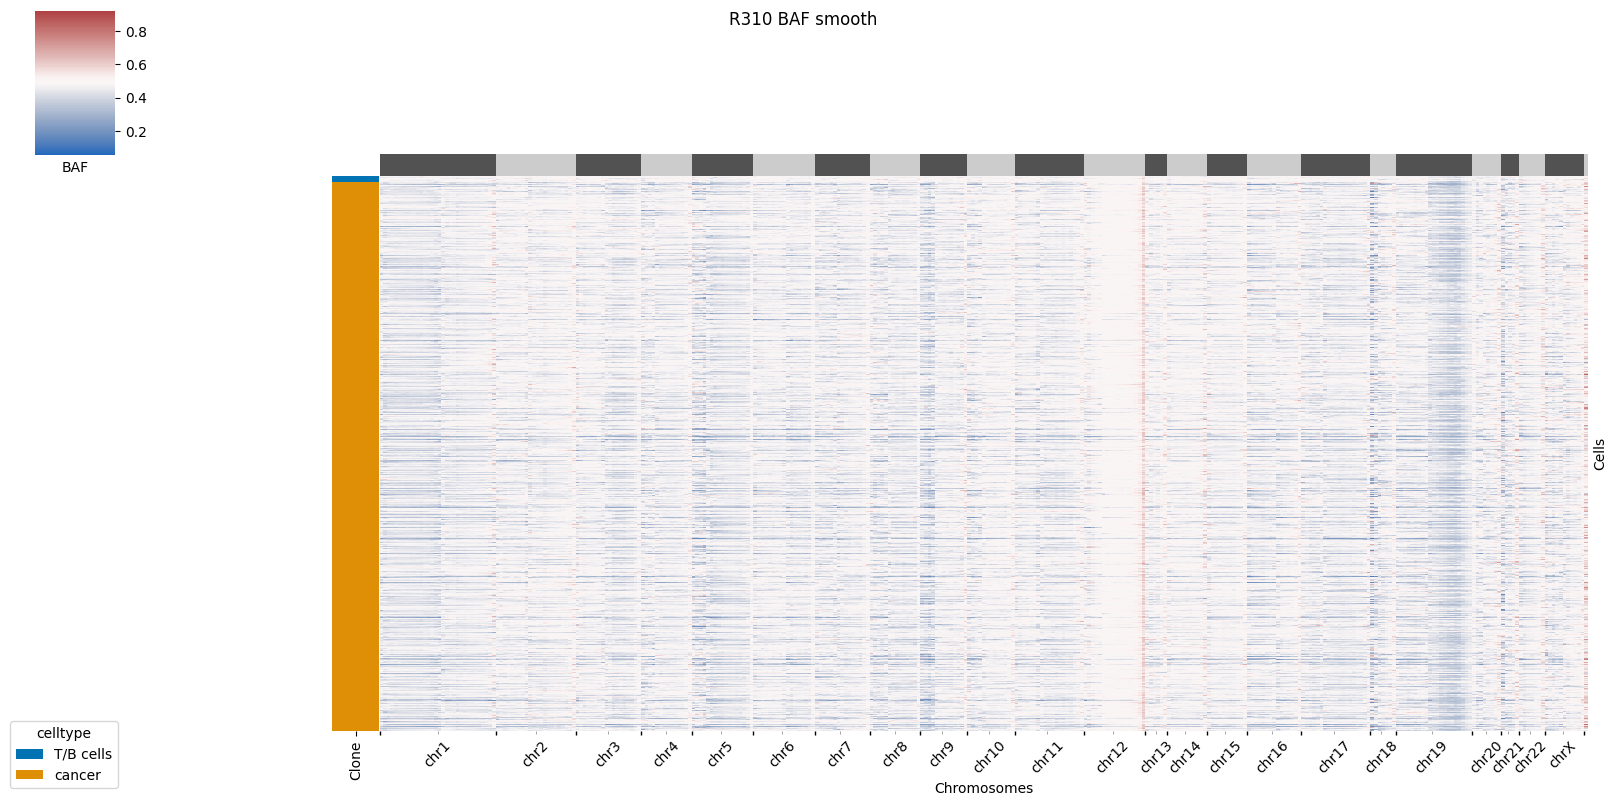

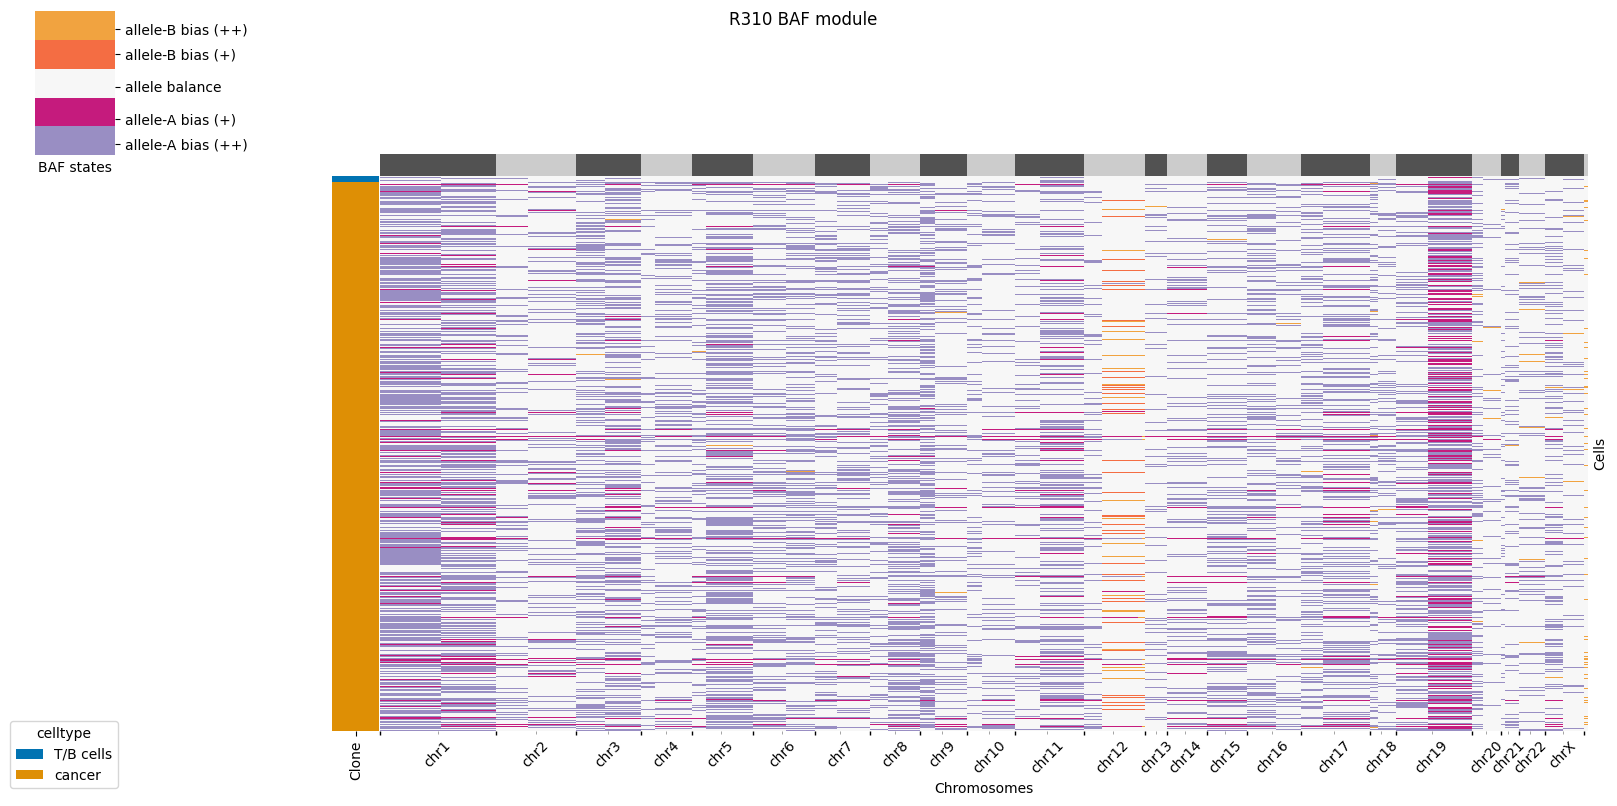

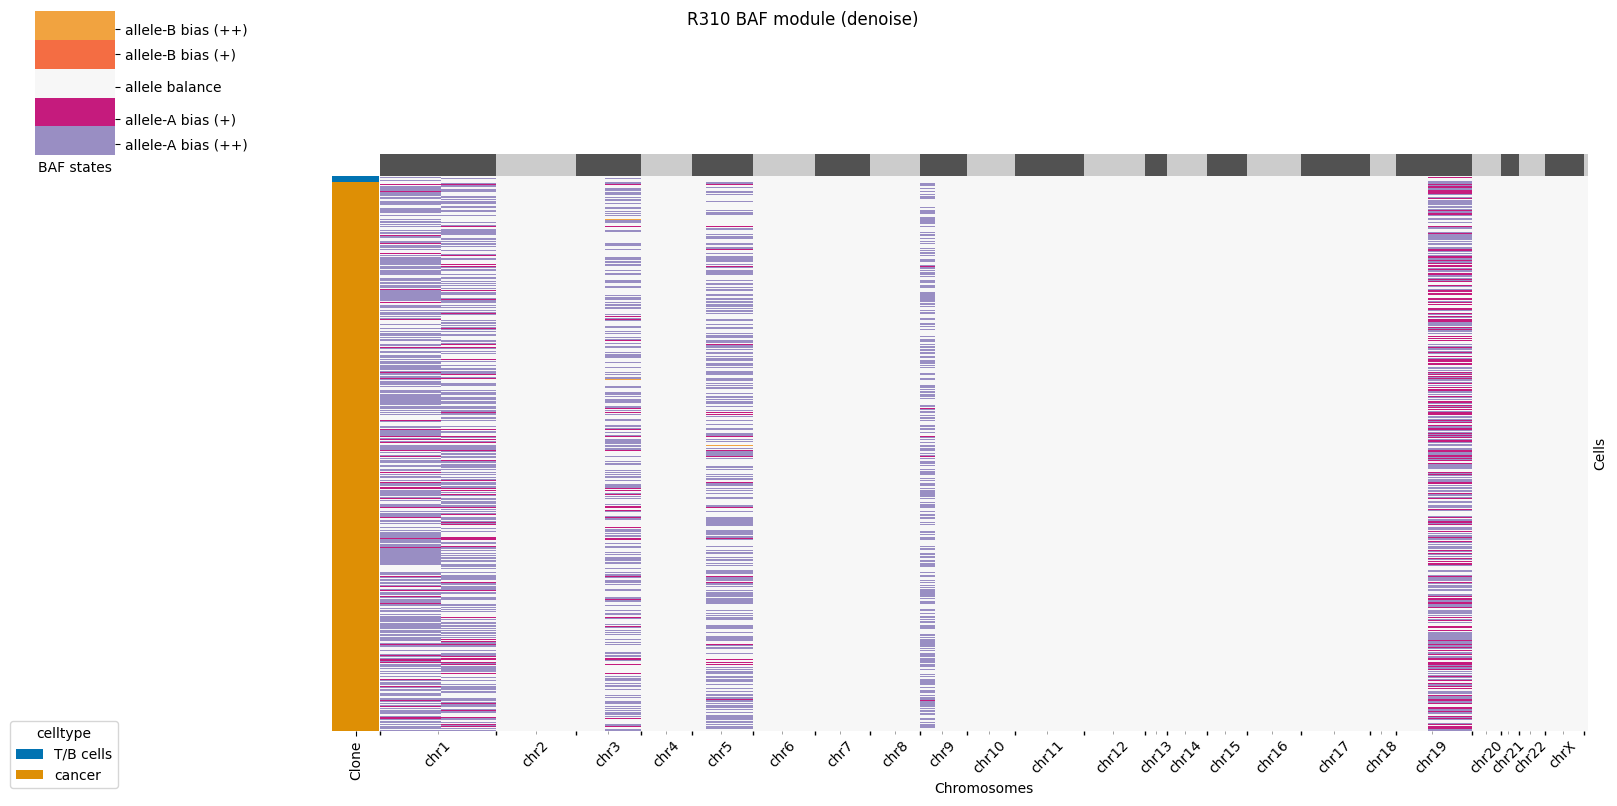

In [111]:
outdir = "R310_pre/xclone_out/"
xconfig_baf = xclone.XCloneConfig(dataset_name="R310", module="BAF")
xconfig_baf.outdir = outdir
xconfig_baf.cell_anno_key = "celltype"
xconfig_baf.ref_celltype = "T/B cells"   # adjust

# key: now this can be True because RDR exists
xconfig_baf.update_info_from_rdr = False

BAF_res = xclone.model.run_BAF(BAF_adata, config_file=xconfig_baf)
BAF_res.write_h5ad(os.path.join(outdir, "BAF_result.h5ad"))

In [3]:
outdir = "R310_pre/xclone_out/"
BAF_res = sc.read_h5ad(os.path.join(outdir, "BAF_result.h5ad"))
RDR_res = sc.read_h5ad(os.path.join(outdir, "RDR_result.h5ad"))

In [4]:
autosomes = [str(i) for i in range(1, 23)]

RDR_use = RDR_res[:, RDR_res.var["chr"].astype(str).isin(autosomes)].copy()
BAF_use = BAF_res[:, BAF_res.var["chr"].astype(str).isin(autosomes)].copy()

print("RDR chrs:", sorted(RDR_use.var["chr"].astype(str).unique()))
print("BAF chrs:", sorted(BAF_use.var["chr"].astype(str).unique()))
print("RDR vars:", RDR_use.n_vars, "BAF vars:", BAF_use.n_vars)

RDR chrs: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '3', '4', '5', '6', '7', '8', '9']
BAF chrs: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '3', '4', '5', '6', '7', '8', '9']
RDR vars: 6041 BAF vars: 321


In [5]:
RDR_use.var.index = [str(i) for i in range(RDR_use.shape[1])]

In [ ]:
xconfig_c = xclone.XCloneConfig(dataset_name="R310", module="Combine")
xconfig_c.outdir = outdir
xconfig_c.cell_anno_key = "celltype"
xconfig_c.ref_celltype = "T/B cells"

CNV_res = xclone.model.run_combine(RDR_use, BAF_use, config_file=xconfig_c)


[XClone Combination module running]************************
[XClone] BAF extend bins to genes.
[XClone data checking]: RDR and BAF in same cell order.
No genes in this bin: 6108 6208 , skip this bin.
No genes in this bin: 6208 6308 , skip this bin.
No genes in this bin: 6308 6408 , skip this bin.
No genes in this bin: 6408 6508 , skip this bin.
No genes in this bin: 6508 6608 , skip this bin.
No genes in this bin: 6608 6708 , skip this bin.
No genes in this bin: 6708 6808 , skip this bin.
No genes in this bin: 6808 6908 , skip this bin.
No genes in this bin: 6908 7008 , skip this bin.
No genes in this bin: 7008 7108 , skip this bin.
No genes in this bin: 7108 7138 , skip this bin.
No genes in this bin: 7138 7238 , skip this bin.
No genes in this bin: 7238 7338 , skip this bin.
No genes in this bin: 7338 7438 , skip this bin.
No genes in this bin: 7438 7538 , skip this bin.
No genes in this bin: 7538 7638 , skip this bin.
No genes in this bin: 7638 7738 , skip this bin.
No genes in this

In [6]:
combine = sc.read_h5ad("R310_pre/xclone_out/data/combined_final.h5ad")

In [8]:
combine.layers["corrected_prob"]

array([[[[1.21302546e-07, 1.98639892e-08, 0.00000000e+00,
          1.82651254e-09, 3.42081808e-13],
         [8.37941667e-01, 1.24997143e-01, 3.66618659e-02,
          3.96681550e-04, 2.36305511e-06],
         [1.13897104e-07, 1.69902192e-08, 4.98325874e-09,
          5.39188841e-11, 3.21197935e-13]],

        [[6.50948698e-08, 1.06596591e-08, 0.00000000e+00,
          9.80165712e-10, 1.83572164e-13],
         [8.37941778e-01, 1.24997160e-01, 3.66618699e-02,
          3.96681602e-04, 2.36305542e-06],
         [5.93336403e-08, 8.85089719e-09, 2.59598244e-09,
          2.80885428e-11, 1.67325087e-13]],

        [[3.49318616e-08, 5.72029315e-09, 0.00000000e+00,
          5.25986351e-10, 9.85103349e-14],
         [8.37941837e-01, 1.24997169e-01, 3.66618720e-02,
          3.96681630e-04, 2.36305559e-06],
         [3.09095219e-08, 4.61082447e-09, 1.35236227e-09,
          1.46325664e-11, 8.71670507e-14]],

        ...,

        [[7.42685447e-08, 9.57686940e-08, 0.00000000e+00,
          8.6